<h1> MNIST in Pytorch <h1>

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [22]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))])
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = transform, download = True)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False)

In [23]:
# len(train_loader.dataset)
test_dataset[0][0].shape

torch.Size([1, 28, 28])

In [24]:
# Creating our NN

class MNIST_NN(nn.Module):

    def __init__(self):
        super().__init__()

        #Convolutional Layers
        self.conv1 = nn.Conv2d(1,32,3,1,1)
        self.conv2 = nn.Conv2d(32,64,3,1,1)

        #Fully connected Layers
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):

        #Convolutional Layers and Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)

        x = x.view(-1,7*7*64)

        #Fully connected Layers

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x,dim = 1)

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [26]:
torch.manual_seed(1)
model = MNIST_NN()
model = model.to(device)
model

MNIST_NN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
optimizer = optim.Adam(model.parameters(),lr =0.001)
criterion = nn.CrossEntropyLoss()

In [28]:
#Save models at checkpoints

def save_checkpoint(model):
    torch.save(model.state_dict(),'models/best.pt')

def last_checkpoint(model):
    
    torch.save(model.state_dict(),'models/last.pt')

In [29]:
def train_nn(epochs):

    model.train()

    test_losses = []
    train_losses = []
    test_crr = 0
    train_crr = 0

    last = 0
    best_acc = 0

    for epoch in range(epochs):
         
        last += 1
        print(f"Epoch : {epoch+1}")


        for count, (X_train,y_train) in enumerate(train_loader):
            
            X_train,y_train = X_train.to(device), y_train.to(device)            
            optimizer.zero_grad()

            y_pred = model(X_train)

            loss = criterion(y_pred, y_train)

            train_losses.append(loss.detach().numpy())

            predicted = torch.max(y_pred.data, 1)[1]
            train_crr += (predicted == y_train).sum().item()
            
            loss.backward()
            optimizer.step()

            if count %200 == 0 :
                print(f"Train dataset: {count * len(X_train)} / {len(train_loader.dataset)} , Accuracy {100. * count / len(train_loader): .0f}% , Loss {loss:.6f}")    


        with torch.no_grad():

            t_loss = 0
            test_crr = 0

            model.eval()

            for k, (X_test,y_test) in enumerate(test_loader):

                X_test,y_test = X_test.to(device), y_test.to(device)
            
                y_eval = model(X_test)

                predicted = torch.max(y_eval.data, 1)[1] # Adding up correct predictions
                test_crr += (predicted == y_test).sum().item() # T=1 F=0 and sum away


            t_loss = criterion(y_eval, y_test)
            test_losses.append(t_loss.detach().numpy())


        eval_acc = 100.00 * (test_crr/k)

        print(f"Test dataset: Accuracy {test_crr} / {len(test_loader.dataset)} , Accuracy {100. * test_crr / len(test_loader.dataset): .0f}% , Loss {t_loss:.6f}")


        if eval_acc > best_acc:
            best_acc = eval_acc
            save_checkpoint(model)
            
        if last == epochs:
            last_checkpoint(model)



In [30]:
train_nn(10)

Epoch : 1
Train dataset: 0 / 60000 , Accuracy  0% , Loss 2.325196
Train dataset: 6400 / 60000 , Accuracy  11% , Loss 0.113714
Train dataset: 12800 / 60000 , Accuracy  21% , Loss 0.121940
Train dataset: 19200 / 60000 , Accuracy  32% , Loss 0.049819
Train dataset: 25600 / 60000 , Accuracy  43% , Loss 0.018969
Train dataset: 32000 / 60000 , Accuracy  53% , Loss 0.090769
Train dataset: 38400 / 60000 , Accuracy  64% , Loss 0.149405
Train dataset: 44800 / 60000 , Accuracy  75% , Loss 0.004915
Train dataset: 51200 / 60000 , Accuracy  85% , Loss 0.016028
Train dataset: 57600 / 60000 , Accuracy  96% , Loss 0.178755
Test dataset: Accuracy 9867 / 10000 , Accuracy  99% , Loss 0.000992
Epoch : 2
Train dataset: 0 / 60000 , Accuracy  0% , Loss 0.036795
Train dataset: 6400 / 60000 , Accuracy  11% , Loss 0.007527
Train dataset: 12800 / 60000 , Accuracy  21% , Loss 0.003238
Train dataset: 19200 / 60000 , Accuracy  32% , Loss 0.211297
Train dataset: 25600 / 60000 , Accuracy  43% , Loss 0.042110
Train dat

In [31]:
#Testing new Data with our model


test_data_new = DataLoader(test_dataset, batch_size=10000, shuffle= False)

with torch.no_grad():
    correct = 0 
    for l,(X_test,y_test) in enumerate(test_data_new):
        y_eval = model(X_test)
        predicted = torch.max(y_eval,1)[1]
        correct += (predicted == y_test ).sum()

In [32]:
correct

tensor(9903)

1


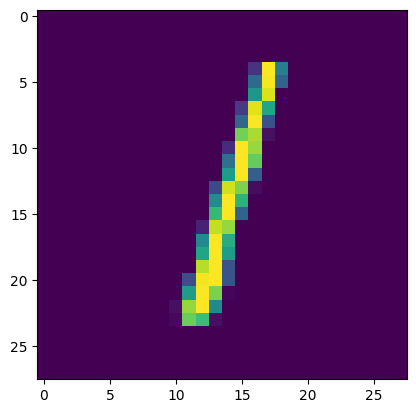

In [33]:
td= test_dataset[2]
plt.imshow(td[0].reshape(28,28))
print(td[1])

In [34]:
model.eval()

MNIST_NN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

This Digit is probably 4


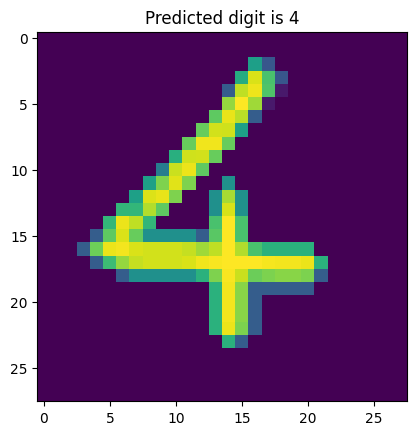

In [37]:
# img = cv2.imread(f'./Test/Digit{999}.jpg')[:,:,0]
# img = np.invert(np.array([img]))

img = cv2.imread(f'./Test/Digits/{4}.png')[:,:,0]
img =(np.array([img]))

img_tensor = torch.FloatTensor(img).unsqueeze(0)

with torch.no_grad():

    model.eval()

    prediction = model(img_tensor)

print(f"This Digit is probably {prediction.argmax()}")

plt.imshow(img[0])
plt.title(f'Predicted digit is {prediction.argmax()}')
plt.show()